## Time-series modelling using tensorflow

### Check for GPU availabiltiy

In [1]:
!nvidia-smi

Mon Dec 18 14:56:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download and load the data

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-12-18 14:56:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.005s  

2023-12-18 14:56:00 (37.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
# Load the data
import pandas as pd

# Read the csv data
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
df.head(10)

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566
5,BTC,2013-10-06,120.65533,121.33866,121.85216,120.55450
6,BTC,2013-10-07,121.79500,120.65533,121.99166,120.43199
7,BTC,2013-10-08,123.03300,121.79500,123.64016,121.35066
8,BTC,2013-10-09,124.04900,123.03300,124.78350,122.59266
9,BTC,2013-10-10,125.96116,124.04900,128.01683,123.81966


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Date                 2787 non-null   object 
 2   Closing Price (USD)  2787 non-null   float64
 3   24h Open (USD)       2787 non-null   float64
 4   24h High (USD)       2787 non-null   float64
 5   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(2)
memory usage: 130.8+ KB


In [5]:
# Check count of records in the data
len(df)

2787

In [6]:
# Since, modelling only done on closing price, therefore taking that only
bitcoin_prices = pd.DataFrame(df[['Date','Closing Price (USD)']]).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices.head(10)

,Date,Price
0,2013-10-01,123.65499
1,2013-10-02,125.45500
2,2013-10-03,108.58483
3,2013-10-04,118.67466
4,2013-10-05,121.33866
5,2013-10-06,120.65533
6,2013-10-07,121.79500
7,2013-10-08,123.03300
8,2013-10-09,124.04900
9,2013-10-10,125.96116


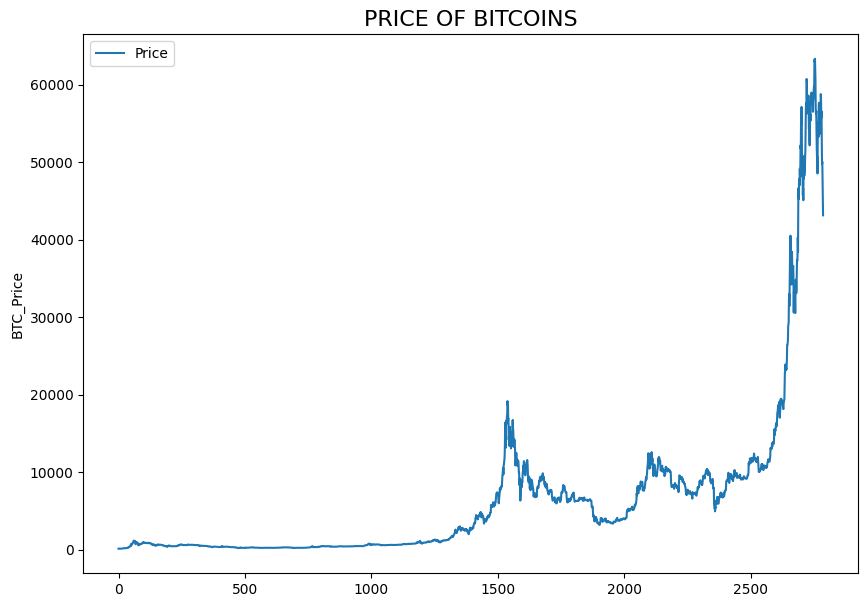

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC_Price')
plt.title('PRICE OF BITCOINS', fontsize=16)
plt.legend();

### Creating test and train splits for the time series data

In [8]:
# Get timestamps (dates of the closing prices)
from datetime import datetime
timesteps = [datetime.strptime(data, '%Y-%m-%d') for data in bitcoin_prices['Date']]
btc_price = [data for data in bitcoin_prices['Price']]
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [9]:
# Get bitcoin data array
prices = bitcoin_prices['Price'].to_numpy()
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [10]:
# Create test and train splits
split_size = int(0.8*len(btc_price))  # 80% train, 20% test

# Create train data slpits
X_train, y_train = timesteps[:split_size], btc_price[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], btc_price[split_size:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

2229 2229 558 558


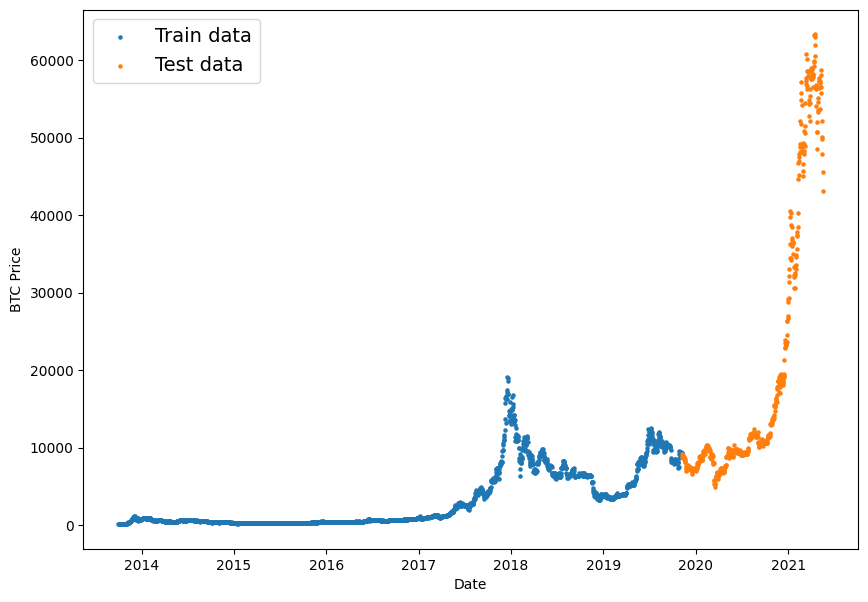

In [11]:
# Plot the train-test splitted data
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show();

In [12]:
# Making a function to create test-train splits for the time-series data
def make_test_train_splits(timesteps, price, split_size=0.7):
  # Get the split size
  split_size = int(len(timesteps) * (1-split_size))
  # Create train sets
  X_train, y_train = timesteps[:split_size], price[:split_size]

  # Create test sets
  X_test, y_test = timesteps[split_size:], price[split_size:]

  return X_train, y_train, X_test, y_test

### Creating a plotting function

In [13]:
# Plot the time-series data
def plot_time_series(timesteps, values,
                     format='.', start = 0,
                     end = None, label=None):
  # Plot the time series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True);

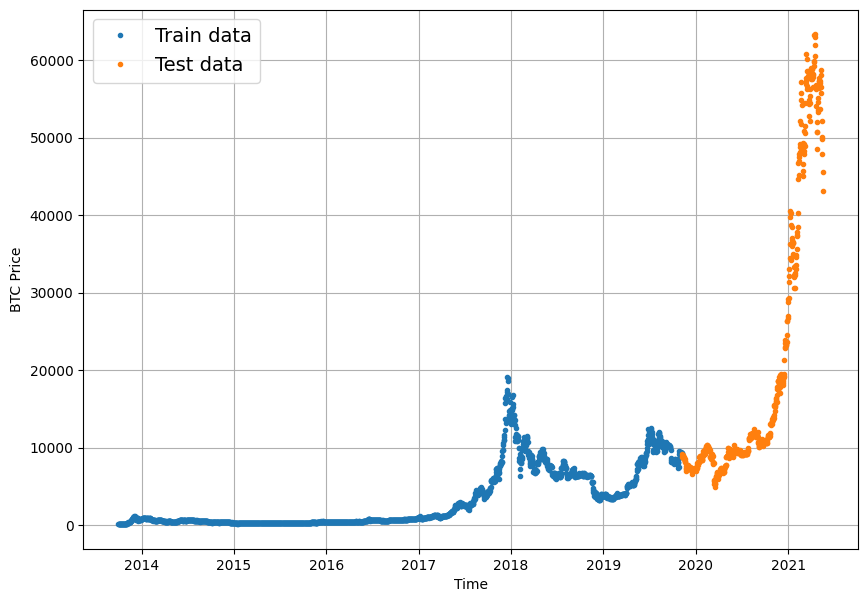

In [14]:
# Plotting using the functions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

### Making function to calculate and get the evaluation metrics

In [15]:
import tensorflow as tf

In [16]:
# Function for MASE (Mean absolute scaled error)
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))

  return mae / mae_no_seasonality

In [17]:
# Make a function to get all evaluation metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

### Formatting data into windows and horizons

In [18]:
HORIZON = 1
WINDOW_SIZE = 7

In [19]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  return x[:,:-horizon], x[:,-horizon:]

In [20]:
# Testing the labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(18)+1, axis=0), horizon=HORIZON+3)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] -> Label: [15 16 17 18]


In [21]:
import numpy as np

In [22]:
# Creating a function to create windowed data
def make_windows(x, window_size = 7, horizon=1):
  # Create window of specific size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  print(f"Window step:\n {window_step}")

  # Creating a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size + horizon - 1)), axis=0).T
  print(f"Window indexes:\n {window_indexes[:10], window_indexes[-3:]}")
  print(f'Window shape: {window_indexes.shape}')

  # Index on the target array with 2D array of multiple windows
  window_array = x[window_indexes]
  print(f'Windowed array: {window_array}')

  # Get labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)

  return windows, labels

In [23]:
full_windows, full_labels = make_windows(prices)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 9, 10, 11, 12, 13, 14, 15, 16]]), array([[2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784],
       [2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785],
       [2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786]]))
Window shape: (2780, 8)
Windowed array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55

In [24]:
for window, label in zip(full_windows[:10], full_labels[:10]):
  print(f'Window: {window}\nLabel: {label}\n')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
Label: [123.033]

Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
Label: [124.049]

Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
Label: [125.96116]

Window: [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]
Label: [125.27966]

Window: [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]
Label: [125.9275]

Window: [120.65533 121.795   123.033   124.049   125.96116 125.27966 125.9275 ]
Label: [126.38333]

Window: [121.795   123.033   124.049   125.96116 125.27966 125.9275  126.38333]
Label: [135.24199]

Window: [123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199]
Label: [133.20333]

Window: [124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333]
Label: [142.76333]

Window: [125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333]
Label: [137.92333]



### Turning windows into training and test sets

In [25]:
# Make train/test splits
def make_train_test_splits_windows(windows, labels, test_split = 0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows, train_labels = windows[:split_size], labels[:split_size]
  test_windows, test_labels = windows[split_size:], labels[split_size:]

  return train_windows, train_labels, test_windows, test_labels

In [26]:
# Get the train and tests splits of the windowed data
train_windows, train_labels, test_windows, test_labels = make_train_test_splits_windows(full_windows,
                                                                                        full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

## Performing modelling experiments

### Creating different callbacks

In [27]:
# Model checkpoint callback
def create_model_checkpoint(save_dir):
  return tf.keras.callbacks.ModelCheckpoint(filepath=save_dir,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            verbose = 0,
                                            monitor = 'val_loss',
                                            mode='min')

### Model 1: Window = 7, horizon = 1

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

# set the random seed
tf.random.set_seed(42)

# Create the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_1')

# Compile the model
model_1.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mae', 'mape'])

# Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs = 100,
                              verbose = 1,
                              batch_size = 64,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(save_dir = 'model_exp/model_1_w7_h1')])

Epoch 1/100
35/35 [==============================] - 7s 30ms/step - loss: 800.5750 - mae: 800.5750 - mape: 24.9476 - val_loss: 1437.2291 - val_mae: 1437.2291 - val_mape: 7.1782
Epoch 2/100
35/35 [==============================] - 1s 17ms/step - loss: 193.1555 - mae: 193.1555 - mape: 5.4269 - val_loss: 1025.4247 - val_mae: 1025.4246 - val_mape: 4.5899
Epoch 3/100
35/35 [==============================] - 1s 17ms/step - loss: 156.6128 - mae: 156.6128 - mape: 4.3101 - val_loss: 764.8926 - val_mae: 764.8926 - val_mape: 3.3857
Epoch 4/100
35/35 [==============================] - 1s 17ms/step - loss: 134.5306 - mae: 134.5306 - mape: 3.5964 - val_loss: 700.2432 - val_mae: 700.2432 - val_mape: 3.1292
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 130.3358 - mae: 130.3358 - mape: 3.4668 - val_loss: 808.7738 - val_mae: 808.7738 - val_mape: 3.8969
Epoch 6/100
35/35 [==============================] - 0s 11ms/step - loss: 125.3621 - mae: 125.3621 - mape: 3.4015 - val_loss:

In [29]:
# Evaluate the model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 590.0390 - mae: 590.0390 - mape: 2.6852


[590.0390014648438, 590.0390014648438, 2.6851987838745117]

In [30]:
# Load the best weights model
model_1.load_weights('model_exp/model_1_w7_h1')

# Evaluate on the test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 566.1943 - mae: 566.1943 - mape: 2.5543


[566.1943359375, 566.1943359375, 2.5542898178100586]

In [31]:
# Make predictions
model_1.predict(test_windows)

18/18 [==============================] - 0s 2ms/step


array([[ 8821.134 ],
       [ 8770.863 ],
       [ 9065.369 ],
       [ 8750.849 ],
       [ 8727.535 ],
       [ 8752.825 ],
       [ 8682.242 ],
       [ 8496.941 ],
       [ 8464.17  ],
       [ 8536.387 ],
       [ 8226.539 ],
       [ 8100.2075],
       [ 8067.823 ],
       [ 7635.723 ],
       [ 7261.8423],
       [ 7267.091 ],
       [ 7046.8623],
       [ 7175.147 ],
       [ 7139.5693],
       [ 7513.568 ],
       [ 7420.5923],
       [ 7731.612 ],
       [ 7579.999 ],
       [ 7407.0024],
       [ 7325.932 ],
       [ 7325.2793],
       [ 7221.2104],
       [ 7380.2383],
       [ 7521.768 ],
       [ 7553.8438],
       [ 7558.7285],
       [ 7359.573 ],
       [ 7242.4443],
       [ 7195.1855],
       [ 7192.3755],
       [ 7233.7256],
       [ 7097.661 ],
       [ 7104.8696],
       [ 6898.3535],
       [ 6589.8525],
       [ 7366.7803],
       [ 7219.0996],
       [ 7147.5854],
       [ 7274.3267],
       [ 7287.0537],
       [ 7186.0537],
       [ 7231.49  ],
       [ 7230

### Making predictions with a model

In [32]:
# Create a function to make predictions
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [33]:
# Get predictions from the model
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8821.134, 8770.863, 9065.369, 8750.849, 8727.535, 8752.825,
        8682.242, 8496.941, 8464.17 , 8536.387], dtype=float32)>,
 556)

In [34]:
# Evaluate the model results
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 566.1943,
 'mse': 1146275.8,
 'rmse': 1070.6427,
 'mape': 2.5542898,
 'mase': 0.69477195}

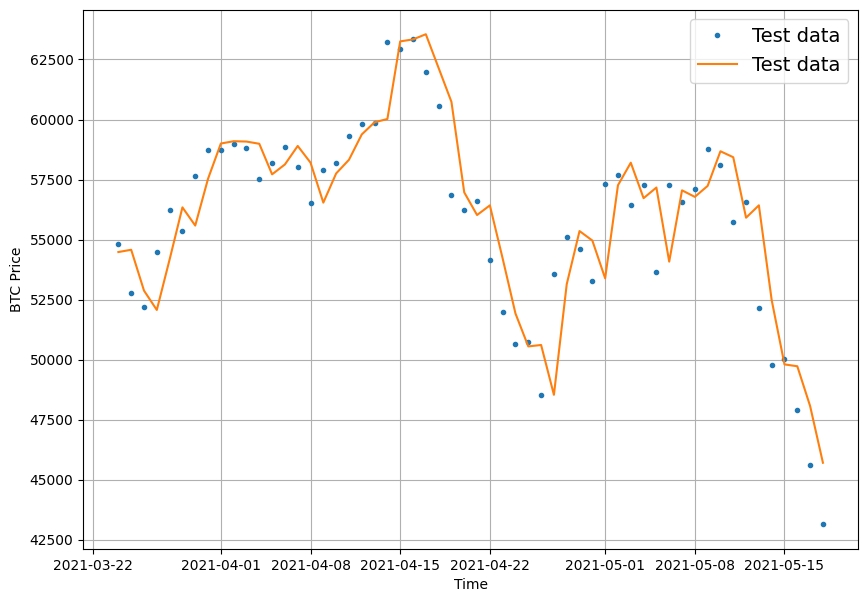

In [35]:
# Plotting the predictions
offset = 500
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_1_preds, start = offset,
                 format = '-', label='Test data')

#### Plot loss curves

In [36]:
# Making a function to plot loss curves
def plot_loss_curves(history, metrics_to_plot=['loss']):
  plt.figure(figsize=(13, 9))
  for index, metric in enumerate(metrics_to_plot):
    ax = plt.subplot(len(metrics_to_plot), 1, index+1)
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f"val_{metric}"], label=f'Training val_{metric}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric}')
    plt.title(f'Train and val {metric} curves')
    plt.tight_layout()
    plt.legend();

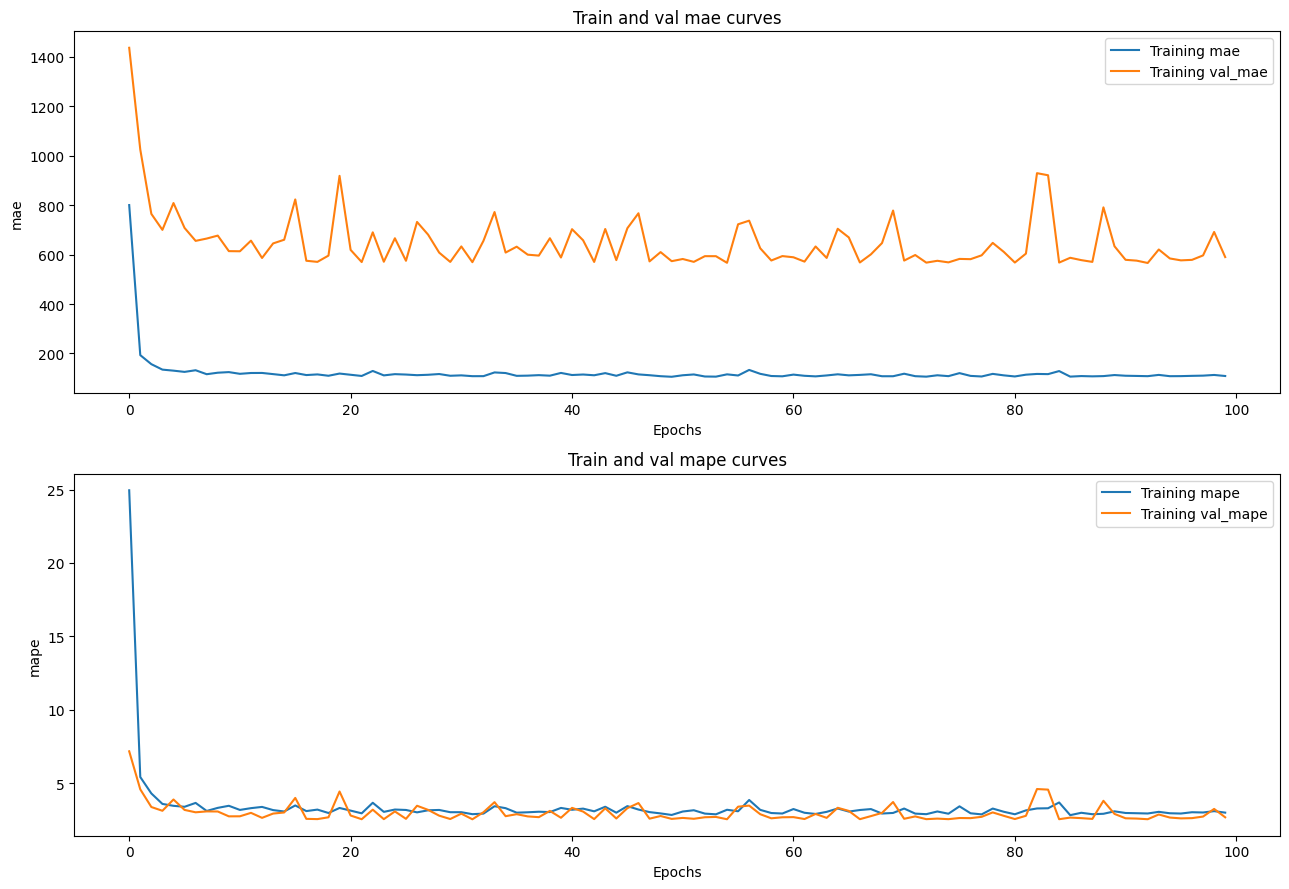

In [37]:
plot_loss_curves(model_1_history,
                 metrics_to_plot=['mae', 'mape'])

#### Training model_1 for more epochs

In [38]:
# Compile the model
model_1.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mae', 'mape'])

# Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs = 256,
                              initial_epoch = 100,
                              verbose = 1,
                              batch_size = 64,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(save_dir = 'model_exp/model_1_w7_h1_more')])

Epoch 101/256
35/35 [==============================] - 1s 10ms/step - loss: 130.2005 - mae: 130.2005 - mape: 3.7666 - val_loss: 575.2136 - val_mae: 575.2136 - val_mape: 2.6024
Epoch 102/256
35/35 [==============================] - 0s 5ms/step - loss: 105.7165 - mae: 105.7165 - mape: 2.8532 - val_loss: 584.3863 - val_mae: 584.3863 - val_mape: 2.6483
Epoch 103/256
35/35 [==============================] - 0s 4ms/step - loss: 109.4408 - mae: 109.4408 - mape: 2.9823 - val_loss: 629.4522 - val_mae: 629.4522 - val_mape: 2.9251
Epoch 104/256
35/35 [==============================] - 0s 4ms/step - loss: 115.6451 - mae: 115.6451 - mape: 3.2120 - val_loss: 578.6077 - val_mae: 578.6077 - val_mape: 2.6146
Epoch 105/256
35/35 [==============================] - 0s 5ms/step - loss: 117.3178 - mae: 117.3178 - mape: 3.2302 - val_loss: 725.8356 - val_mae: 725.8356 - val_mape: 3.4628
Epoch 106/256
35/35 [==============================] - 0s 4ms/step - loss: 109.3207 - mae: 109.3207 - mape: 3.0208 - val_los

In [39]:
# Evaluate using the test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 620.4177 - mae: 620.4177 - mape: 2.8967


[620.417724609375, 620.417724609375, 2.896699905395508]

In [40]:
# Load in the best weights model
model_1.load_weights('model_exp/model_1_w7_h1_more')

# Evaluate on the test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 565.5643 - mae: 565.5643 - mape: 2.5557


[565.5643310546875, 565.5643310546875, 2.555720806121826]

### Model 2: Windows = 30, horizon = 1

In [41]:
HORIZON = 1
WINDOW_SIZE = 30

In [42]:
# Make the windowed dataset
full_windows, full_labels = make_windows(prices,
                                         window_size = WINDOW_SIZE,
                                         horizon = HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
Window indexes:
 (array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
       [ 6,  7,  8,  9,

(2757, 2757)

In [43]:
# Make train and test windows
train_windows, train_labels, test_windows, test_labels = make_train_test_splits_windows(windows = full_windows,
                                                                                        labels=full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [44]:
# set the random seed
tf.random.set_seed(42)

# Create the model
model_2 = Sequential([
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(HORIZON, activation = 'linear'),
], name = 'model_2')

# Compile the model
model_2.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mae', 'mse', 'mape'])

# Fit the model
model_2_history = model_2.fit(train_windows,
                              train_labels,
                              epochs = 128,
                              batch_size = 16,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(save_dir = 'model_exp/model_2_w30_h1')]
                              )

Epoch 1/128
138/138 [==============================] - 3s 6ms/step - loss: 371.9473 - mae: 371.9473 - mse: 687530.8750 - mape: 11.2794 - val_loss: 1380.2750 - val_mae: 1380.2750 - val_mse: 4856733.0000 - val_mape: 6.1816
Epoch 2/128
138/138 [==============================] - 1s 5ms/step - loss: 217.6220 - mae: 217.6220 - mse: 215886.8281 - mape: 6.3586 - val_loss: 895.4363 - val_mae: 895.4363 - val_mse: 2659080.0000 - val_mape: 3.8003
Epoch 3/128
138/138 [==============================] - 1s 5ms/step - loss: 217.1323 - mae: 217.1323 - mse: 216532.8594 - mape: 6.2747 - val_loss: 840.4743 - val_mae: 840.4743 - val_mse: 2397584.0000 - val_mape: 3.7718
Epoch 4/128
138/138 [==============================] - 1s 5ms/step - loss: 186.5003 - mae: 186.5003 - mse: 166693.8906 - mape: 5.3620 - val_loss: 1654.4581 - val_mae: 1654.4581 - val_mse: 6979134.0000 - val_mape: 8.2480
Epoch 5/128
138/138 [==============================] - 1s 4ms/step - loss: 183.7234 - mae: 183.7234 - mse: 161136.8594 - ma

In [45]:
# Evaluate the model
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 855.3948 - mae: 855.3948 - mse: 2065167.2500 - mape: 4.1375


[855.3948364257812, 855.3948364257812, 2065167.25, 4.1374664306640625]

In [46]:
# Get the best weights model
model_2.load_weights('model_exp/model_2_w30_h1')

# Evaluate using the model
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 588.6302 - mae: 588.6302 - mse: 1214202.6250 - mape: 2.6554


[588.6301879882812, 588.6301879882812, 1214202.625, 2.6553573608398438]

In [47]:
# Get predictions from the model
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10], len(model_2_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8772.999 , 8823.692 , 8728.58  , 8521.069 , 8374.38  , 8354.62  ,
        8165.4316, 8158.73  , 8071.124 , 7691.095 ], dtype=float32)>,
 552)

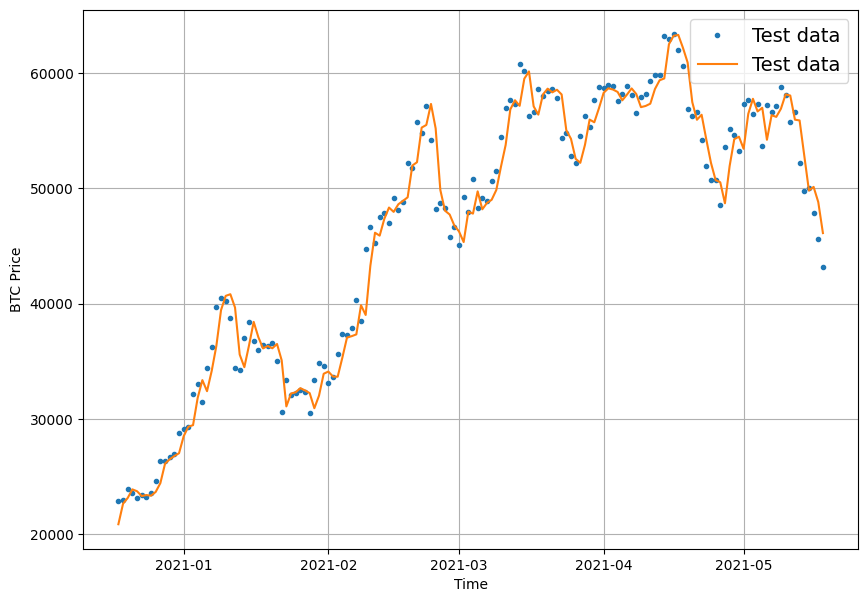

In [48]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_2_preds, start = offset,
                 format = '-', label='Test data')

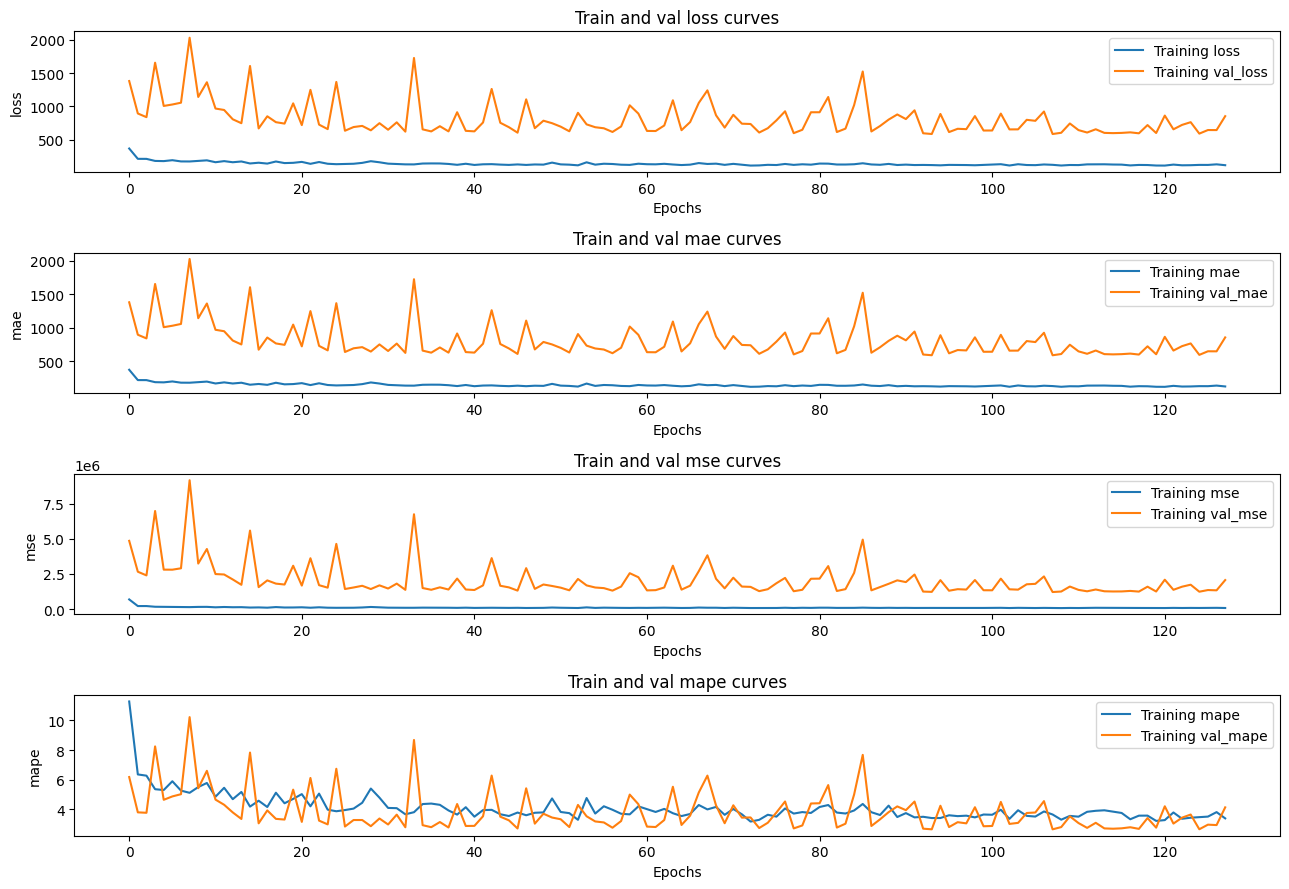

In [49]:
# Plot the loss curves
plot_loss_curves(model_2_history,
                 metrics_to_plot=['loss', 'mae', 'mse', 'mape'])

In [50]:
# Get model results
model_2_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 588.6303,
 'mse': 1214202.8,
 'rmse': 1101.9087,
 'mape': 2.6553571,
 'mase': 0.6940012}

In [51]:
model_1_results

{'mae': 566.1943,
 'mse': 1146275.8,
 'rmse': 1070.6427,
 'mape': 2.5542898,
 'mase': 0.69477195}

### Model 3: Using Conv1D

In [52]:
HORIZON = 1
WINDOW_SIZE = 7

In [53]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices,
                                         window_size=WINDOW_SIZE,
                                         horizon = HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 9, 10, 11, 12, 13, 14, 15, 16]]), array([[2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784],
       [2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785],
       [2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786]]))
Window shape: (2780, 8)
Windowed array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55

(2780, 2780)

In [54]:
# Create test train splits
train_windows, train_labels, test_windows, test_labels = make_train_test_splits_windows(full_windows,
                                                                                        full_labels)

In [55]:
# Checking shape of one sample of data
train_windows[0], train_windows[0].shape

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 (7,))

In [56]:
# Reshape the data for input
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [57]:
# set the random seed
tf.random.set_seed(42)

# Create the model
model_3 = Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters = 128, kernel_size=5, padding='causal', activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name = 'model_3_conv1d')

# Compile the model
model_3.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mae', 'mse', 'mape']
                )

# Fit the model
model_3_history = model_3.fit(train_windows,
                              train_labels,
                              epochs = 128,
                              batch_size = 8,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(save_dir='model_exp/model_3_conv1d')])

Epoch 1/128
278/278 [==============================] - 4s 5ms/step - loss: 423.3865 - mae: 423.3865 - mse: 1539934.3750 - mape: 12.1694 - val_loss: 980.6687 - val_mae: 980.6687 - val_mse: 2978128.5000 - val_mape: 4.3129
Epoch 2/128
278/278 [==============================] - 1s 4ms/step - loss: 176.3801 - mae: 176.3801 - mse: 149916.6406 - mape: 5.0974 - val_loss: 1450.6688 - val_mae: 1450.6688 - val_mse: 4922002.0000 - val_mape: 6.9889
Epoch 3/128
278/278 [==============================] - 1s 5ms/step - loss: 180.5528 - mae: 180.5528 - mse: 151171.7031 - mape: 5.1472 - val_loss: 775.0388 - val_mae: 775.0388 - val_mse: 1916159.2500 - val_mape: 3.4272
Epoch 4/128
278/278 [==============================] - 2s 6ms/step - loss: 167.2122 - mae: 167.2122 - mse: 132915.7812 - mape: 4.8670 - val_loss: 1199.4838 - val_mae: 1199.4838 - val_mse: 3871295.0000 - val_mape: 6.0302
Epoch 5/128
278/278 [==============================] - 1s 5ms/step - loss: 162.1414 - mae: 162.1414 - mse: 121940.4766 - m

In [58]:
# Evaluate on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 591.2010 - mae: 591.2010 - mse: 1208950.5000 - mape: 2.6404


[591.2010498046875, 591.2010498046875, 1208950.5, 2.6404054164886475]

In [59]:
# Get the best weights model
model_3.load_weights('model_exp/model_3_conv1d')

# Evaluate on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 562.7447 - mae: 562.7447 - mse: 1152579.0000 - mape: 2.5094


[562.7446899414062, 562.7446899414062, 1152579.0, 2.509417772293091]

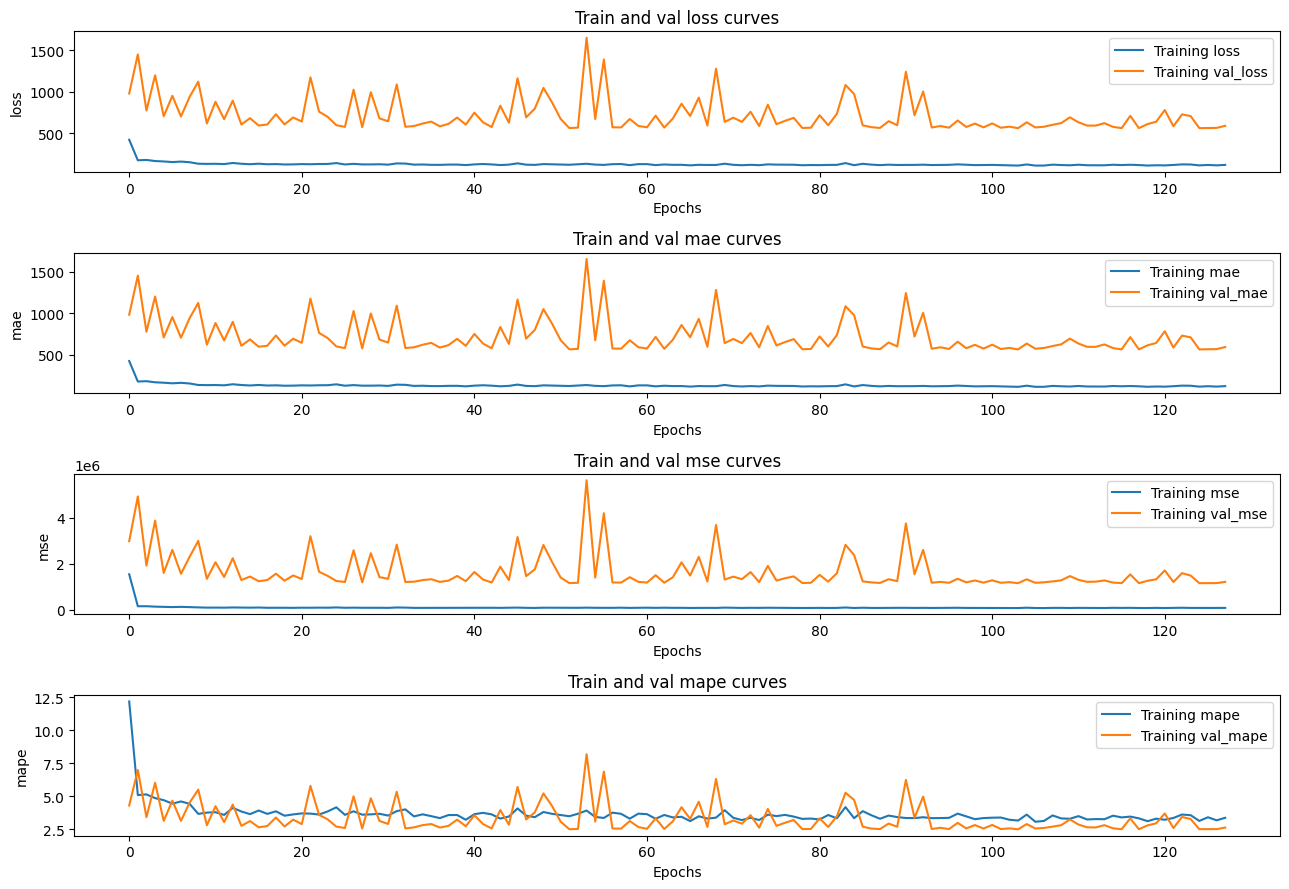

In [60]:
# Plot the loss curves
plot_loss_curves(model_3_history,
                 metrics_to_plot = ['loss', 'mae', 'mse', 'mape'])

In [61]:
# Get predictions from the model
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10], len(model_3_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8850.428, 8798.242, 9048.45 , 8778.527, 8753.122, 8733.627,
        8685.805, 8533.975, 8461.687, 8538.069], dtype=float32)>,
 556)

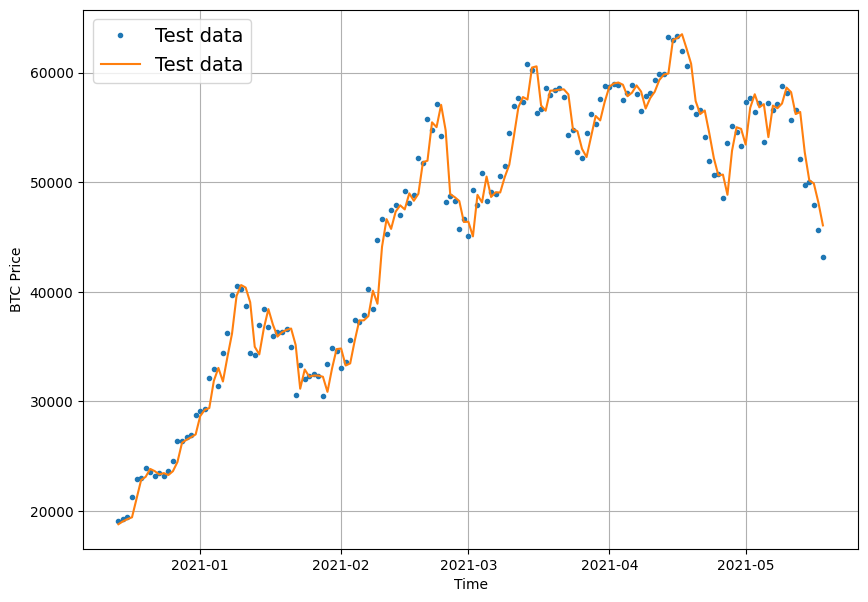

In [62]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_3_preds, start = offset,
                 format = '-', label='Test data')

In [63]:
# Get model results
model_3_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': 562.7447,
 'mse': 1152579.0,
 'rmse': 1073.5823,
 'mape': 2.509418,
 'mase': 0.68302774}

In [64]:
model_1_results

{'mae': 566.1943,
 'mse': 1146275.8,
 'rmse': 1070.6427,
 'mape': 2.5542898,
 'mase': 0.69477195}

In [65]:
model_2_results

{'mae': 588.6303,
 'mse': 1214202.8,
 'rmse': 1101.9087,
 'mape': 2.6553571,
 'mase': 0.6940012}

### Model 4: LSTMs

In [80]:
# set the random seed
tf.random.set_seed(42)

# Create the model
inputs = layers.Input(shape = (WINDOW_SIZE,1))
x = layers.LSTM(128, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON, activation='linear')(x)

model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_lstm')

In [81]:
# Compile the model
model_4.compile(loss='mae',
                optimizer = Adam(),
                metrics = ['mae', 'mse'])

# Fit the model
model_4_history = model_4.fit(train_windows, train_labels,
                              epochs = 128,
                              batch_size = 16,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_4_lstm'
                              )])

Epoch 1/128
139/139 [==============================] - 4s 12ms/step - loss: 453.8814 - mae: 453.8814 - mse: 1498007.6250 - val_loss: 1428.9390 - val_mae: 1428.9390 - val_mse: 4850262.5000
Epoch 2/128
139/139 [==============================] - 1s 7ms/step - loss: 306.9762 - mae: 306.9762 - mse: 567965.8750 - val_loss: 1419.7115 - val_mae: 1419.7115 - val_mse: 6443191.0000
Epoch 3/128
139/139 [==============================] - 1s 7ms/step - loss: 247.4567 - mae: 247.4567 - mse: 289981.5938 - val_loss: 1371.7578 - val_mae: 1371.7578 - val_mse: 5256656.5000
Epoch 4/128
139/139 [==============================] - 1s 7ms/step - loss: 215.4511 - mae: 215.4511 - mse: 219644.3281 - val_loss: 1153.3712 - val_mae: 1153.3712 - val_mse: 4429093.0000
Epoch 5/128
139/139 [==============================] - 1s 7ms/step - loss: 224.6764 - mae: 224.6764 - mse: 236010.5938 - val_loss: 1182.1722 - val_mae: 1182.1722 - val_mse: 4602328.5000
Epoch 6/128
139/139 [==============================] - 1s 7ms/step -

In [82]:
# Evaluate the model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 11ms/step - loss: 602.7543 - mae: 602.7543 - mse: 1238138.6250


[602.7543334960938, 602.7543334960938, 1238138.625]

In [83]:
# Get the best weighted model
model_4.load_weights('model_exp/model_4_lstm')

# Evaluate the model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 563.7324 - mae: 563.7324 - mse: 1148930.3750


[563.732421875, 563.732421875, 1148930.375]

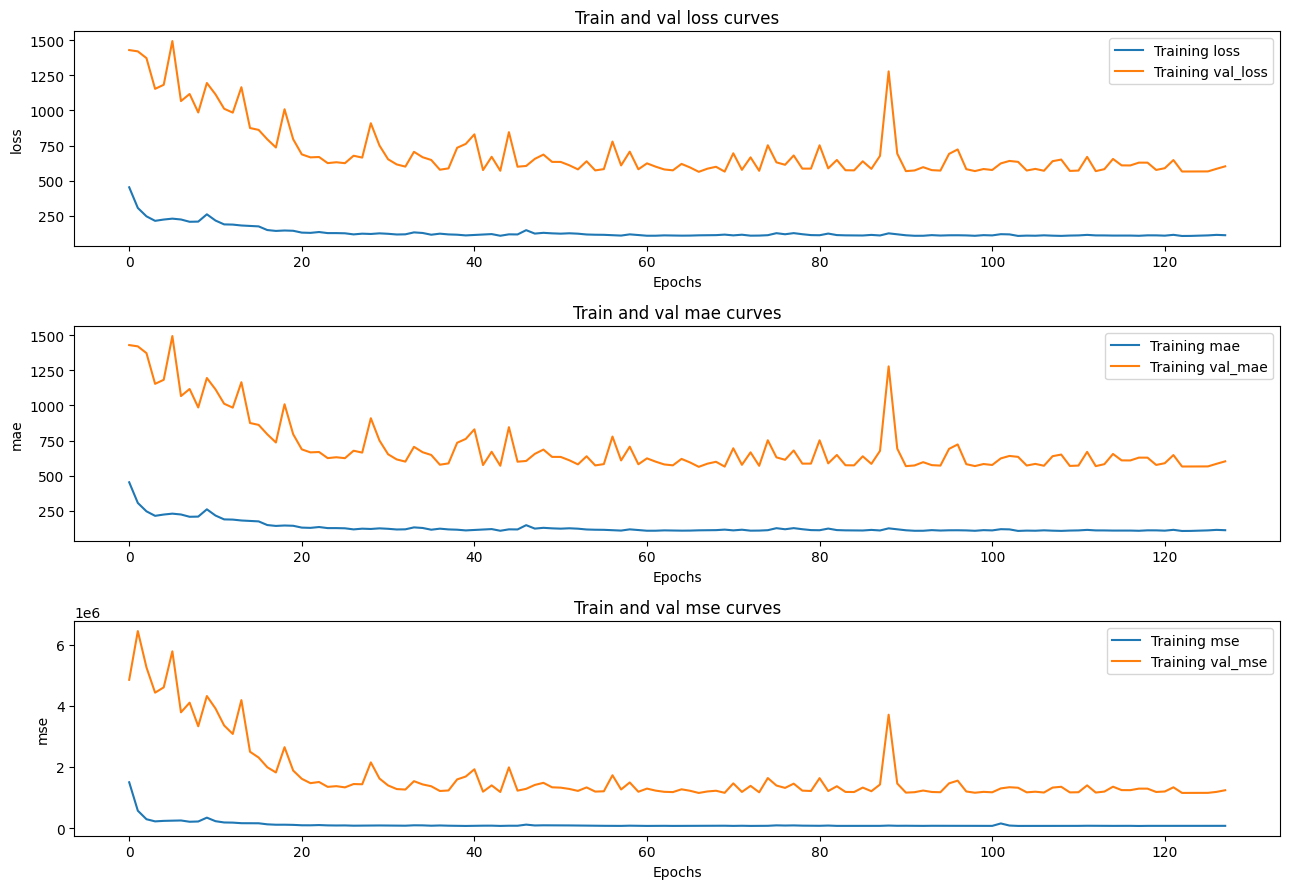

In [85]:
# Plot the loss curves
plot_loss_curves(model_4_history,
                 metrics_to_plot = ['loss', 'mae', 'mse'])

In [86]:
# Get predictions from the model
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10], len(model_4_preds)

18/18 [==============================] - 0s 6ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8851.753 , 8810.028 , 9058.834 , 8767.5205, 8761.688 , 8764.277 ,
        8678.116 , 8530.561 , 8483.215 , 8542.999 ], dtype=float32)>,
 556)

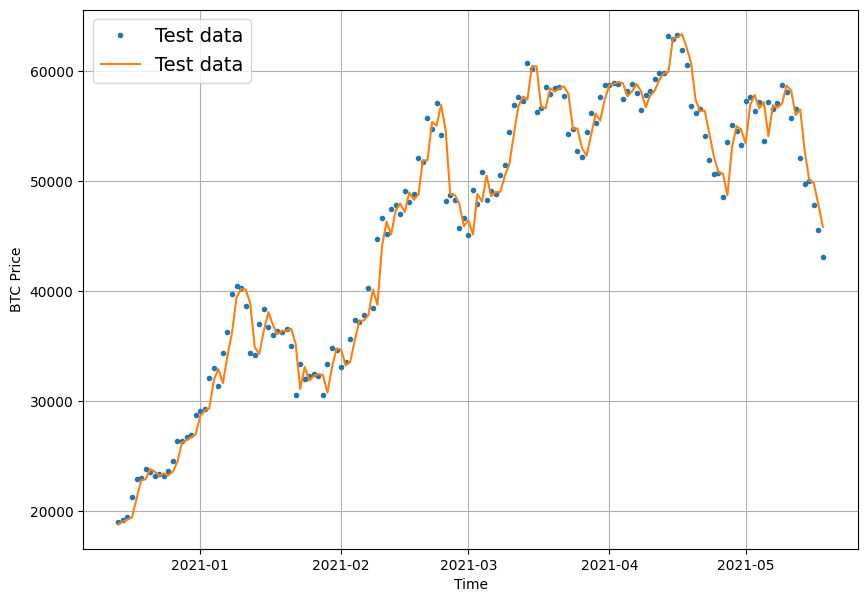

In [87]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_4_preds, start = offset,
                 format = '-', label='Test data')

In [88]:
# Get model results
model_4_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 563.7324,
 'mse': 1148930.4,
 'rmse': 1071.8817,
 'mape': 2.5114102,
 'mase': 0.6832435}

In [89]:
model_1_results

{'mae': 566.1943,
 'mse': 1146275.8,
 'rmse': 1070.6427,
 'mape': 2.5542898,
 'mase': 0.69477195}

### Model 5: model with more LSTM layers

In [111]:
# set the random seed
tf.random.set_seed(42)

# Create the model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(64, return_sequences = True, activation = 'relu')(x)
x = layers.LSTM(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
outputs = layers.Dense(HORIZON, activation = 'linear')(x)

model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_lstm_more')

In [112]:
# Compile the model
model_5.compile(loss='mae',
                optimizer = Adam(),
                metrics = ['mae', 'mse'])

# Fit the model
model_5_history = model_5.fit(train_windows, train_labels,
                              epochs = 128,
                              batch_size = 16,
                              validation_data = (test_windows, test_labels),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_5_lstm_more'
                              )])

Epoch 1/128
139/139 [==============================] - 4s 11ms/step - loss: 958.2399 - mae: 958.2399 - mse: 5375225.5000 - val_loss: 1071.7759 - val_mae: 1071.7759 - val_mse: 3231728.7500
Epoch 2/128
139/139 [==============================] - 1s 10ms/step - loss: 179.7694 - mae: 179.7694 - mse: 166334.8125 - val_loss: 926.7712 - val_mae: 926.7712 - val_mse: 2840777.7500
Epoch 3/128
139/139 [==============================] - 2s 13ms/step - loss: 159.0459 - mae: 159.0459 - mse: 135464.4219 - val_loss: 863.0652 - val_mae: 863.0652 - val_mse: 2478622.7500
Epoch 4/128
139/139 [==============================] - 2s 16ms/step - loss: 165.9108 - mae: 165.9108 - mse: 134326.7188 - val_loss: 790.4305 - val_mae: 790.4305 - val_mse: 2092792.1250
Epoch 5/128
139/139 [==============================] - 2s 12ms/step - loss: 162.4797 - mae: 162.4797 - mse: 132943.0156 - val_loss: 845.4713 - val_mae: 845.4713 - val_mse: 2344990.7500
Epoch 6/128
139/139 [==============================] - 2s 11ms/step - lo

In [113]:
# Evaluate the model
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 621.5744 - mae: 621.5744 - mse: 1297385.2500


[621.5744018554688, 621.5744018554688, 1297385.25]

In [115]:
# Load the best weights model
model_5.load_weights('model_exp/model_5_lstm_more')

# Evaluate using the model
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 9ms/step - loss: 566.2567 - mae: 566.2567 - mse: 1162357.7500


[566.2566528320312, 566.2566528320312, 1162357.75]

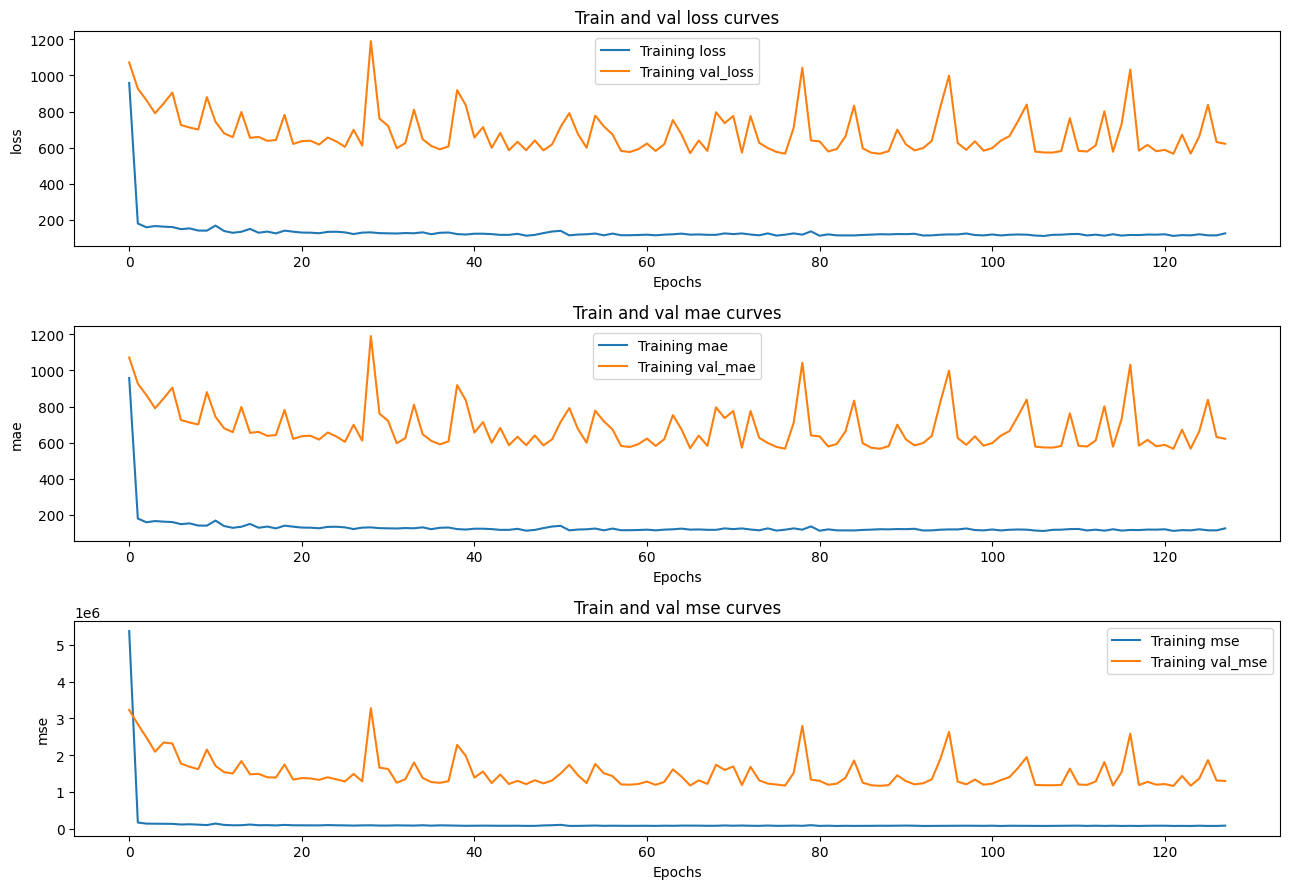

In [116]:
# Plot the loss curves
plot_loss_curves(model_5_history, metrics_to_plot = ['loss', 'mae', 'mse'])

In [117]:
# Get predictions from the model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10], len(model_5_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8868.768, 8814.524, 9074.342, 8783.335, 8752.983, 8766.509,
        8700.475, 8545.906, 8478.649, 8557.767], dtype=float32)>,
 556)

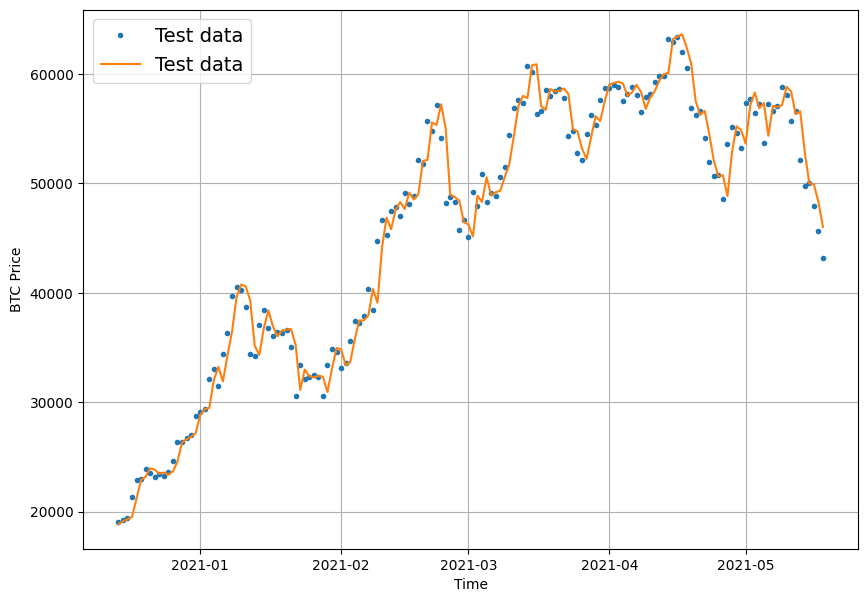

In [118]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_5_preds, start = offset,
                 format = '-', label='Test data')

In [119]:
# Get model results
model_5_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 566.2566,
 'mse': 1162357.8,
 'rmse': 1078.127,
 'mape': 2.5326061,
 'mase': 0.69094324}

### Model 6: Conv1D + LSTM

In [159]:
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Flatten
from tensorflow.keras import regularizers

# set the random seed
tf.random.set_seed(42)

# Creating the model
model_6 = Sequential([
    layers.Input(shape = (WINDOW_SIZE,1)),
    Conv1D(filters = 128, kernel_size = 3, padding = 'causal', activation='relu'),
    Conv1D(filters = 128, kernel_size = 3, padding = 'causal', activation='relu'),
    MaxPooling1D(pool_size = 2),
    Conv1D(filters = 64, kernel_size = 3, padding = 'causal', activation='relu'),
    Conv1D(filters = 64, kernel_size = 3, padding = 'causal', activation='relu'),
    MaxPooling1D(pool_size = 2),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(HORIZON, activation='linear')
], name = 'model_6')

# Compile the model
model_6.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mae', 'mse'])

# Fit the model
model_6_history = model_6.fit(train_windows, train_labels,
                              epochs = 128,
                              validation_data = (test_windows, test_labels),
                              batch_size = 16,
                              callbacks = [create_model_checkpoint(
                                  save_dir ='model_exp/model_6_conv1d_lstm'
                              )]
                              )

Epoch 1/128
139/139 [==============================] - 6s 20ms/step - loss: 789.8278 - mae: 789.7431 - mse: 3774857.0000 - val_loss: 1500.5652 - val_mae: 1500.5081 - val_mse: 7403901.0000
Epoch 2/128
139/139 [==============================] - 1s 10ms/step - loss: 339.5670 - mae: 339.5168 - mse: 507445.8750 - val_loss: 1637.3845 - val_mae: 1637.3379 - val_mse: 8615671.0000
Epoch 3/128
139/139 [==============================] - 1s 9ms/step - loss: 301.3171 - mae: 301.2717 - mse: 426261.1562 - val_loss: 1684.0641 - val_mae: 1684.0199 - val_mse: 8123527.5000
Epoch 4/128
139/139 [==============================] - 1s 9ms/step - loss: 311.0752 - mae: 311.0315 - mse: 426464.9062 - val_loss: 1478.2394 - val_mae: 1478.1962 - val_mse: 7192323.5000
Epoch 5/128
139/139 [==============================] - 1s 9ms/step - loss: 297.5291 - mae: 297.4861 - mse: 404542.7500 - val_loss: 2077.6599 - val_mae: 2077.6177 - val_mse: 10906612.0000
Epoch 6/128
139/139 [==============================] - 1s 9ms/step

In [160]:
model_6.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 1321.3514 - mae: 1321.3345 - mse: 5692280.5000


[1321.3514404296875, 1321.33447265625, 5692280.5]

In [161]:
# Load the best weights
model_6.load_weights('model_exp/model_6_conv1d_lstm')

model_6.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 1246.0660 - mae: 1246.0437 - mse: 4963331.0000


[1246.0660400390625, 1246.043701171875, 4963331.0]

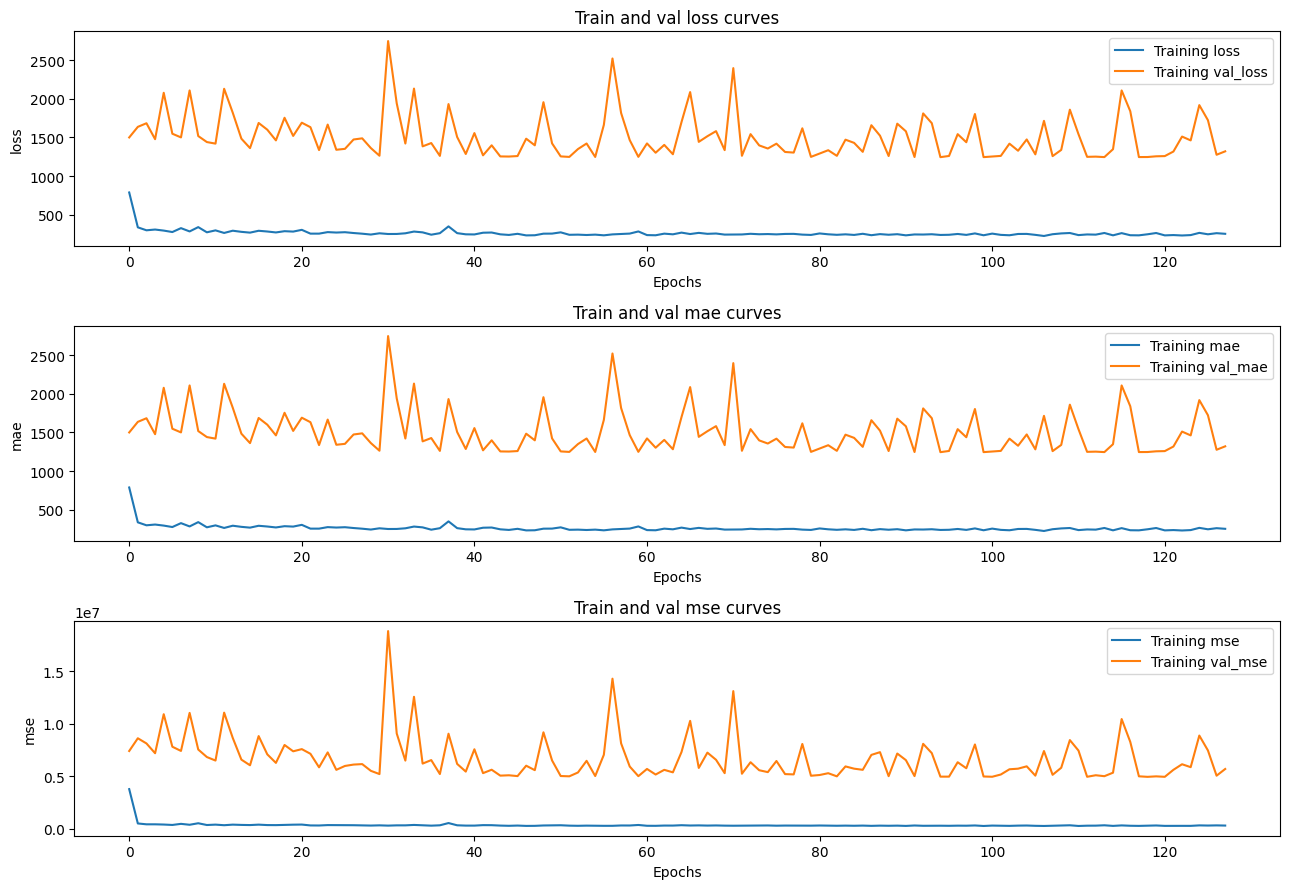

In [162]:
# Plot loss curves
plot_loss_curves(model_6_history, metrics_to_plot = ['loss', 'mae', 'mse'])

In [163]:
# Make predictions using the model
model_6_preds = make_preds(model_6, test_windows)
model_6_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9446.727, 9441.793, 9345.496, 8915.205, 8917.574, 9212.611,
       8824.542, 8855.584, 8879.178, 8763.626], dtype=float32)>

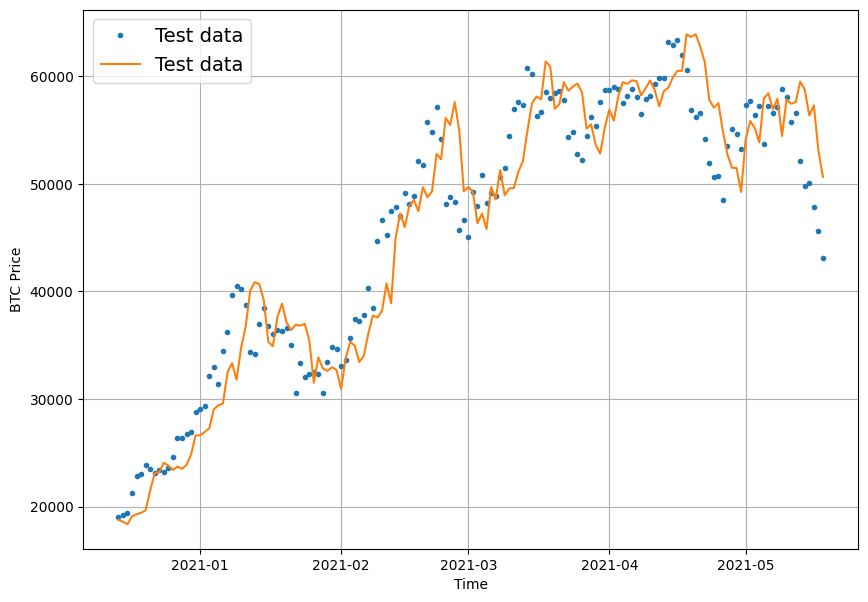

In [164]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_6_preds, start = offset,
                 format = '-', label='Test data')

In [165]:
# Get model results
model_6_results = evaluate_preds(y_true= tf.squeeze(test_labels),
                                 y_pred = model_6_preds)
model_6_results

{'mae': 1246.0438,
 'mse': 4963330.5,
 'rmse': 2227.8533,
 'mape': 5.5680904,
 'mase': 0.88510245}

### Model 7: Multivariate model

In [200]:
# Reading and parsing the time-series data
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates = ['Date'],
                 index_col = ['Date'])  # parse the data column and tell column 1 is a data-time column
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':"Price"})
bitcoin_prices[:10]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


In [201]:
import numpy as np
from datetime import datetime

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days, len(bitcoin_prices)


(1012, 2414, 2787)

In [202]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


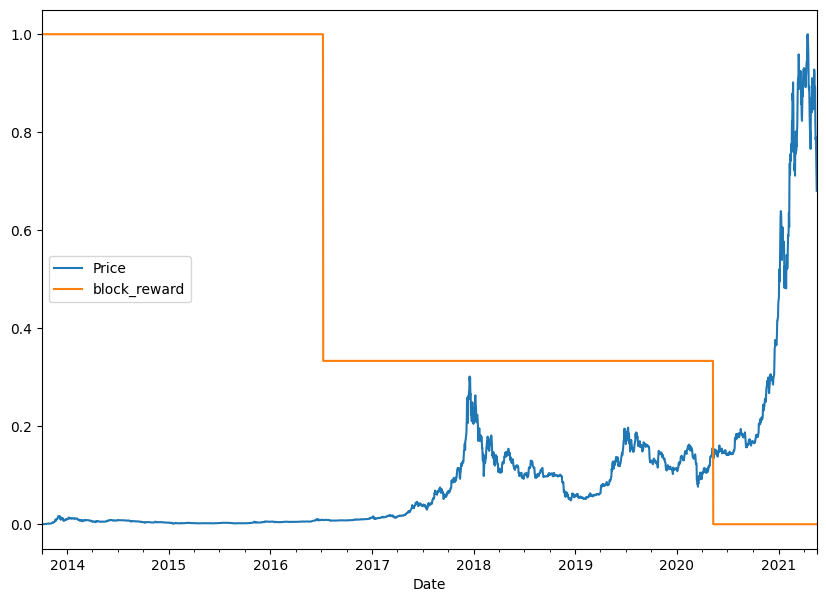

In [203]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [204]:
scaled_price_block_df.head()

,Price,block_reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


#### Make the windowed dataset

In [205]:
HORIZON = 1
WINDOW_SIZE = 7

In [206]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [208]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [209]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [210]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [211]:
X_train.head(5)

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [216]:
X_train.shape

(2224, 8)

In [246]:
# set the random seed
tf.random.set_seed(42)

model_7 = Sequential([
    layers.Input(shape=(WINDOW_SIZE+HORIZON)),
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters = 128, kernel_size=4, padding='causal', activation='relu'),
    layers.Conv1D(filters = 128, kernel_size=4, padding='causal', activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name = 'model_7_conv1d_multi')

# Compile the model
model_7.compile(loss = 'mae',
                optimizer = Adam(),
                metrics = ['mse']
                )

# Fit the model
model_7_history = model_7.fit(X_train, y_train,
                              epochs = 128,
                              batch_size = 16,
                              verbose = 0,
                              validation_data = (X_test, y_test),
                              callbacks = [create_model_checkpoint(save_dir='model_exp/model_7_conv1d_multi')])

In [247]:
# Evaluate the model
model_7.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 581.0533 - mse: 1199381.6250


[581.0532836914062, 1199381.625]

In [248]:
# Get the best weights model
model_7.load_weights('model_exp/model_7_conv1d_multi')

# Evaluate using the model
model_7.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 563.9249 - mse: 1155426.0000


[563.9248657226562, 1155426.0]

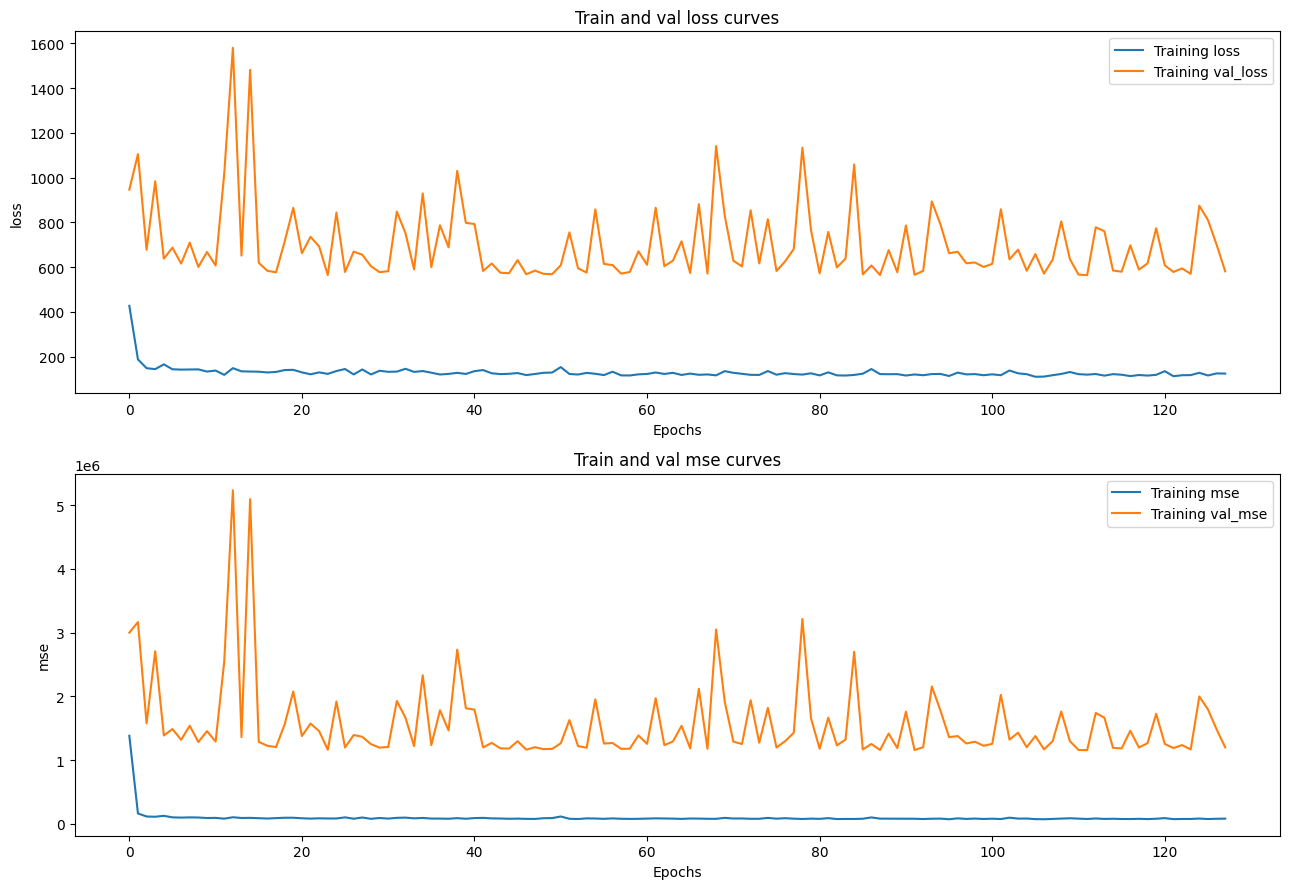

In [249]:
# Plot the loss curves
plot_loss_curves(model_7_history,
                 metrics_to_plot = ['loss', 'mse'])

In [250]:
# Make predictions using the model
model_7_preds = make_preds(model_7, X_test)
model_7_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8855.463, 8801.759, 9051.325, 8770.016, 8747.854, 8747.531,
       8680.897, 8534.172, 8465.537, 8538.913], dtype=float32)>

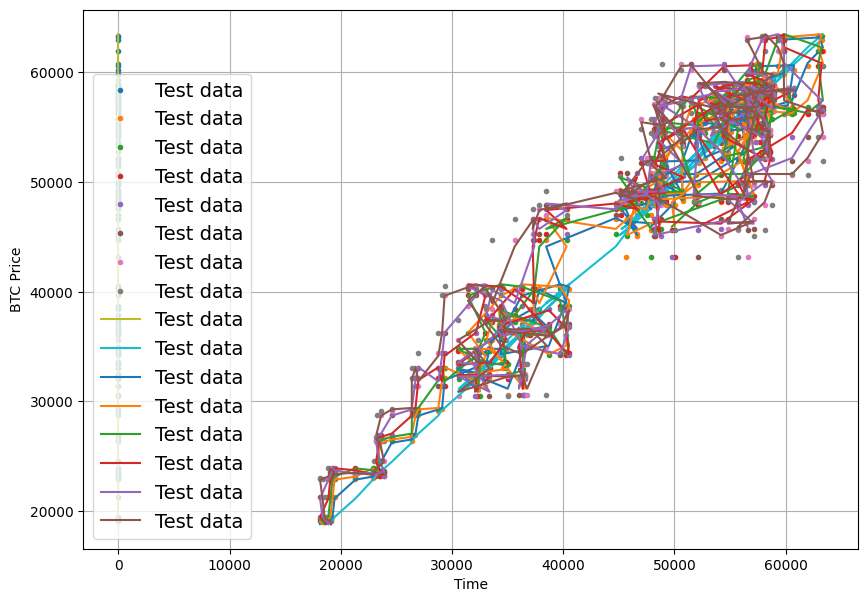

In [251]:
# Plotting the predictions
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0], start = offset, label='Test data')

plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_7_preds, start = offset,
                 format = '-', label='Test data')

In [252]:
# Evaluate preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 563.92487,
 'mse': 1155426.0,
 'rmse': 1074.9075,
 'mape': 2.5147629,
 'mase': 0.6843371}

### Checking overall models results

In [253]:
import pandas as pd
# Get all models results
results_df = pd.DataFrame([model_1_results, model_2_results,
                           model_3_results, model_4_results,
                           model_5_results, model_6_results,
                           model_7_results])

In [254]:
results_df

,mae,mse,rmse,mape,mase
0,566.194275,1146275.750,1070.642700,2.554290,0.694772
1,588.630310,1214202.750,1101.908691,2.655357,0.694001
2,562.744690,1152579.000,1073.582275,2.509418,0.683028
3,563.732422,1148930.375,1071.881714,2.511410,0.683244
4,566.256592,1162357.750,1078.126953,2.532606,0.690943
5,1246.043823,4963330.500,2227.853271,5.568090,0.885102
6,563.924866,1155426.000,1074.907471,2.514763,0.684337


In [257]:
sorted_results = pd.DataFrame({"model_1_7w_1h": model_1_results["mae"],
                               "model_2_30w_1h": model_2_results["mae"],
                               "model_3_conv1d": model_3_results["mae"],
                               "model_4_lstm": model_4_results["mae"],
                               "model_5_lstm_more": model_5_results["mae"],
                               "model_6_conv1d_lstm": model_6_results["mae"],
                               "model_7_multi": model_7_results["mae"]}, index=["mae"]
                              ).T.sort_values(by=["mae"])
sorted_results

,mae
model_3_conv1d,562.744690
model_4_lstm,563.732422
model_7_multi,563.924866
model_1_7w_1h,566.194275
model_5_lstm_more,566.256592
model_2_30w_1h,588.630310
model_6_conv1d_lstm,1246.043823


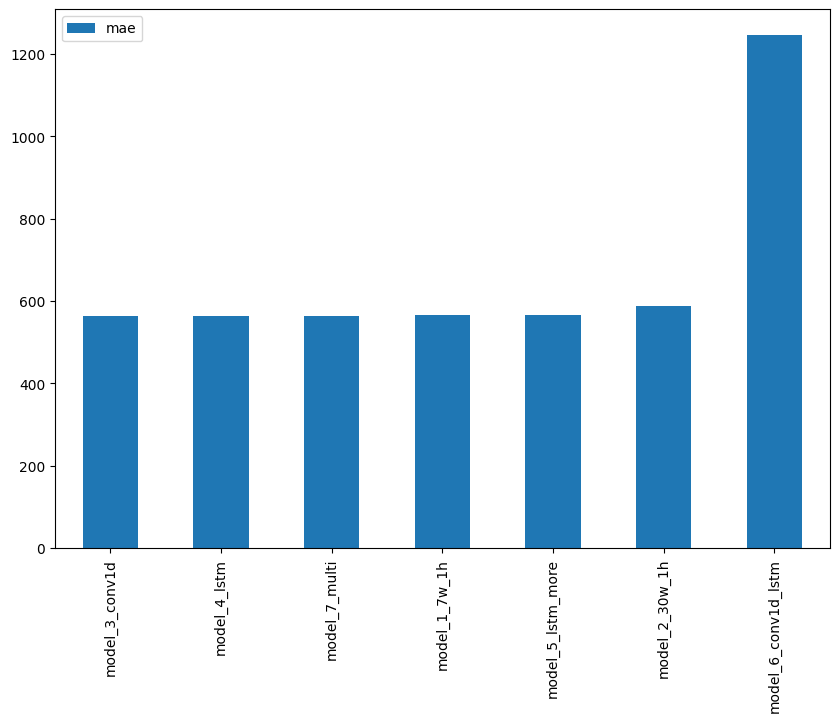

In [258]:
sorted_results.plot(figsize=(10, 7), kind="bar");